# 그래프 생성

LangGraph는 에이전트 워크플로우를 그래프로 모델링합니다. 

그래프를 사용하여 에이전트의 동작을 정의하고, 상태를 관리하며, 로직을 라우팅할 수 있습니다.

## 환경 설정

In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

# 환경 변수 로드
load_dotenv(override=True)
# 추적을 위한 프로젝트 이름 설정
logging.langsmith("LangGraph-V1-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-V1-Tutorial


## Graphs

LangGraph의 핵심은 에이전트 워크플로우를 그래프로 모델링하는 것입니다. 

그래프는 세 가지 핵심 구성 요소를 사용하여 에이전트의 동작을 정의합니다.

1. **State(상태)**: 애플리케이션의 현재 스냅샷을 나타내는 공유 데이터 구조입니다. 모든 데이터 타입이 될 수 있지만, 일반적으로 공유 상태 스키마를 사용하여 정의합니다.

2. **Nodes(노드)**: 에이전트의 로직을 인코딩하는 함수입니다. 현재 상태를 입력으로 받아 일부 계산 또는 부작용을 수행하고, 업데이트된 상태를 반환합니다.

3. **Edges(엣지)**: 현재 상태를 기반으로 다음에 실행할 노드를 결정하는 함수입니다. 조건부 분기 또는 고정 전환이 될 수 있습니다.

노드와 엣지를 결합하여 시간이 지남에 따라 상태를 발전시키는 복잡한 루핑 워크플로우를 만들 수 있습니다.

## StateGraph

`StateGraph`는 사용할 주요 그래프 클래스입니다. 사용자가 정의한 `State` 객체로 매개변수화됩니다.

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


# State 정의
class InternalState(TypedDict):
    input: str
    result: str

# StateGraph 인스턴스 생성
builder = StateGraph(InternalState)

# 노드 함수 정의
def process_node(state: InternalState):
    return {"result": f"처리됨: {state['input']}"}


# 노드 추가
builder.add_node("process", process_node)

# 엣지 추가
builder.add_edge(START, "process")
builder.add_edge("process", END)

# 컴파일
graph = builder.compile()

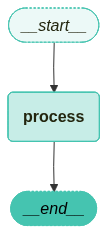

In [4]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

### 그래프 실행

In [5]:
# 그래프 실행
result = graph.invoke({"input": "안녕하세요"})
print(result)

{'input': '안녕하세요', 'result': '처리됨: 안녕하세요'}


## State (상태)

그래프를 정의할 때 가장 먼저 하는 일은 그래프의 `State`를 정의하는 것입니다. State는 다음으로 구성됩니다:

1. **스키마(Schema)**: 그래프의 데이터 구조
2. **리듀서(Reducer) 함수**: 상태에 대한 업데이트를 적용하는 방법을 지정하는 함수

### Schema (스키마)

그래프의 스키마를 지정하는 주요 방법은 `TypedDict`를 사용하는 것입니다.

In [ ]:
from typing_extensions import TypedDict


class BasicState(TypedDict):
    name: str
    age: int
    messages: list[str]

### Reducers (리듀서)

리듀서는 노드의 업데이트가 상태에 어떻게 적용되는지를 이해하는 데 핵심입니다. State의 각 키에는 자체 독립적인 리듀서 함수가 있습니다.

#### 기본 리듀서 (덮어쓰기)

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    foo: int
    bar: str


def node_1(state: State):
    print(f"node_1 - 현재 상태: {state}")
    return {"foo": 2}


def node_2(state: State):
    print(f"node_2 - 현재 상태: {state}")
    return {"bar": "안녕"}


builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

graph = builder.compile()

result = graph.invoke({"foo": 1, "bar": "반가워"})
print(f"최종 결과: {result}")

node_1 - 현재 상태: {'foo': 1, 'bar': '반가워'}
node_2 - 현재 상태: {'foo': 2, 'bar': '반가워'}
최종 결과: {'foo': 2, 'bar': '안녕'}


#### 커스텀 리듀서 (리스트 추가)

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from operator import add
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    foo: int
    bar: Annotated[list[str], add]


def node_1(state: State):
    print(f"node_1 - 현재 상태: {state}")
    return {"foo": 2}


def node_2(state: State):
    print(f"node_2 - 현재 상태: {state}")
    return {"bar": ["새로운 항목"]}


builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

graph = builder.compile()

result = graph.invoke({"foo": 1, "bar": ["기존 항목"]})
print(f"최종 결과: {result}")

node_1 - 현재 상태: {'foo': 1, 'bar': ['기존 항목']}
node_2 - 현재 상태: {'foo': 2, 'bar': ['기존 항목']}
최종 결과: {'foo': 2, 'bar': ['기존 항목', '새로운 항목']}


### Messages를 사용한 상태 관리

대부분의 최신 LLM 제공자는 메시지 목록을 입력으로 받는 채팅 모델 인터페이스를 가지고 있습니다.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


def chatbot_node(state: MessagesState):
    last_message = state["messages"][-1]
    response = f"메시지를 받았습니다: {last_message.content}"
    return {"messages": [AIMessage(content=response)]}


builder = StateGraph(MessagesState)
builder.add_node("chatbot", chatbot_node)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

result = graph.invoke({"messages": [HumanMessage(content="안녕하세요!")]})

print("메시지 목록:")
for msg in result["messages"]:
    print(f"- {msg.__class__.__name__}: {msg.content}")

메시지 목록:
- HumanMessage: 안녕하세요!
- AIMessage: 메시지를 받았습니다: 안녕하세요!


#### MessagesState

`MessagesState`는 사전 구축된 상태입니다.

In [ ]:
from langgraph.graph import MessagesState


class CustomState(MessagesState):
    user_name: str
    context: str

## Nodes (노드)

LangGraph에서 노드는 다음 인자를 받는 Python 함수입니다:

1. `state`: 그래프의 상태
2. `config`: 구성 정보를 포함하는 `RunnableConfig` 객체
3. `runtime`: 런타임 컨텍스트를 포함하는 `Runtime` 객체

In [ ]:
from typing_extensions import TypedDict
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    input: str
    results: str


def plain_node(state: State):
    return {"results": f"처리됨: {state['input']}"}


def node_with_config(state: State, config: RunnableConfig):
    thread_id = config.get("configurable", {}).get("thread_id", "unknown")
    print(f"Thread ID: {thread_id}")
    return {"results": f"안녕, {state['input']}!"}


builder = StateGraph(State)
builder.add_node("plain_node", plain_node)
builder.add_node("node_with_config", node_with_config)
builder.add_edge(START, "plain_node")
builder.add_edge("plain_node", "node_with_config")
builder.add_edge("node_with_config", END)

graph = builder.compile()

result = graph.invoke(
    {"input": "테스트"}, config={"configurable": {"thread_id": "thread-1"}}
)
print(f"결과: {result}")

## Edges (엣지)

엣지는 로직이 어떻게 라우팅되고 그래프가 언제 중지할지를 정의합니다.

### Normal Edges (일반 엣지)

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    value: str


def node_a(state: State):
    print("노드 A 실행")
    return {"value": state["value"] + " -> A"}


def node_b(state: State):
    print("노드 B 실행")
    return {"value": state["value"] + " -> B"}


builder = StateGraph(State)
builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)
builder.add_edge(START, "node_a")
builder.add_edge("node_a", "node_b")
builder.add_edge("node_b", END)

graph = builder.compile()
result = graph.invoke({"value": "시작"})
print(f"결과: {result['value']}")

### Conditional Edges (조건부 엣지)

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    value: int
    path: str


def node_a(state: State):
    print("노드 A 실행")
    return {"value": state["value"]}


def node_b(state: State):
    print("노드 B 실행 (짝수 경로)")
    return {"path": "짝수"}


def node_c(state: State):
    print("노드 C 실행 (홀수 경로)")
    return {"path": "홀수"}


def routing_function(state: State):
    if state["value"] % 2 == 0:
        return "even"
    else:
        return "odd"


builder = StateGraph(State)
builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)
builder.add_node("node_c", node_c)
builder.add_edge(START, "node_a")
builder.add_conditional_edges(
    "node_a", routing_function, {"even": "node_b", "odd": "node_c"}
)
builder.add_edge("node_b", END)
builder.add_edge("node_c", END)

graph = builder.compile()

print("=== 짝수 테스트 ===")
result = graph.invoke({"value": 4})
print(f"결과: {result}")

## Send

`Send`는 동적으로 여러 노드를 병렬로 실행할 수 있게 해주는 기능입니다.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from operator import add
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send


class OverallState(TypedDict):
    subjects: list[str]
    jokes: Annotated[list[str], add]


class JokeState(TypedDict):
    subject: str


def generate_subjects(state: OverallState):
    return {"subjects": ["고양이", "강아지", "새"]}


def generate_joke(state: JokeState):
    joke = f"{state['subject']}에 대한 재미있는 농담"
    return {"jokes": [joke]}


def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


builder = StateGraph(OverallState)
builder.add_node("generate_subjects", generate_subjects)
builder.add_node("generate_joke", generate_joke)
builder.add_edge(START, "generate_subjects")
builder.add_conditional_edges("generate_subjects", continue_to_jokes)
builder.add_edge("generate_joke", END)

graph = builder.compile()
result = graph.invoke({"subjects": []})
print(f"생성된 농담: {result['jokes']}")

## Command

`Command`는 제어 흐름과 상태 업데이트를 결합할 수 있는 기능입니다.

In [ ]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command


class State(TypedDict):
    count: int
    status: str


def decision_node(state: State) -> Command[Literal["continue_node", "end_node"]]:
    new_count = state["count"] + 1
    if new_count < 3:
        return Command(
            update={"count": new_count, "status": "계속 진행"}, goto="continue_node"
        )
    else:
        return Command(update={"count": new_count, "status": "종료"}, goto="end_node")


def continue_node(state: State):
    print(f"계속 진행 중... (카운트: {state['count']})")
    return state


def end_node(state: State):
    print(f"종료 노드 도달 (카운트: {state['count']})")
    return state


builder = StateGraph(State)
builder.add_node("decision_node", decision_node)
builder.add_node("continue_node", continue_node)
builder.add_node("end_node", end_node)
builder.add_edge(START, "decision_node")
builder.add_edge("continue_node", "decision_node")
builder.add_edge("end_node", END)

graph = builder.compile()
result = graph.invoke({"count": 0, "status": "시작"})
print(f"최종 상태: {result}")

## Recursion Limit (재귀 제한)

재귀 제한은 단일 실행 중에 그래프가 실행할 수 있는 최대 슈퍼 스텝 수를 설정합니다.

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.errors import GraphRecursionError


class State(TypedDict):
    count: int


def increment_node(state: State):
    new_count = state["count"] + 1
    print(f"카운트: {new_count}")
    return {"count": new_count}


def should_continue(state: State):
    if state["count"] < 100:
        return "continue"
    return "end"


builder = StateGraph(State)
builder.add_node("increment", increment_node)
builder.add_edge(START, "increment")
builder.add_conditional_edges(
    "increment", should_continue, {"continue": "increment", "end": END}
)

graph = builder.compile()

try:
    result = graph.invoke({"count": 0}, config={"recursion_limit": 5})
except GraphRecursionError as e:
    print(f"재귀 제한 도달: {e}")